In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import git
import sys
import os
import time
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import torch
import yaml
import pdb

from prodict import Prodict

from collections import defaultdict, OrderedDict
from torch.utils.data import DataLoader

from argoverse.data_loading.argoverse_forecasting_loader import ArgoverseForecastingLoader
from argoverse.visualization.visualize_sequences import viz_sequence
from argoverse.map_representation.map_api import ArgoverseMap

repo = git.Repo('.', search_parent_directories=True)
BASE_DIR = repo.working_tree_dir
sys.path.append(BASE_DIR)

import model.datasets.argoverse.dataset as dataset
import model.datasets.argoverse.dataset_utils as dataset_utils 
import model.datasets.argoverse.map_functions as map_functions
from model.datasets.argoverse.dataset import ArgoverseMotionForecastingDataset, seq_collate

avm = ArgoverseMap()

obs_len = 20 # steps
pred_len = 30 # steps
freq = 10 # Hz ("steps/s")
obs_origin = 20 

RAW_DATA_FORMAT = {
    "TIMESTAMP": 0,
    "TRACK_ID": 1,
    "OBJECT_TYPE": 2,
    "X": 3,
    "Y": 4,
    "CITY_NAME": 5,
}

map_features_utils_instance = map_functions.MapFeaturesUtils()

/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Set root_dir to the correct path to your dataset folder

split_name = "val"
root_dir = os.path.join(BASE_DIR,f'data/datasets/argoverse/motion-forecasting/{split_name}/data/')
afl = ArgoverseForecastingLoader(root_dir)
print('Total number of sequences:',len(afl))

files, num_files = dataset_utils.load_list_from_folder(root_dir)

file_id_list = []
root_file_name = None
for file_name in files:
    if not root_file_name:
        root_file_name = os.path.dirname(os.path.abspath(file_name))
    file_id = int(os.path.normpath(file_name).split('/')[-1].split('.')[0])
    file_id_list.append(file_id)
file_id_list.sort()
print("Num files: ", num_files)

Total number of sequences: 39472
Num files:  39472


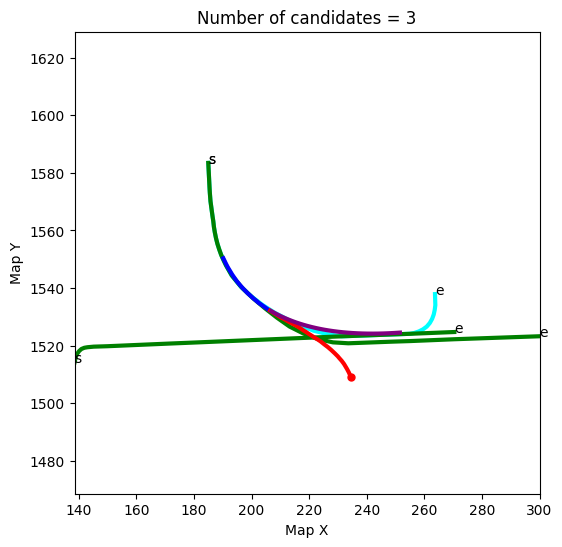

Candidate centerlines using Argoverse forecasting baseline:  0.3525090217590332


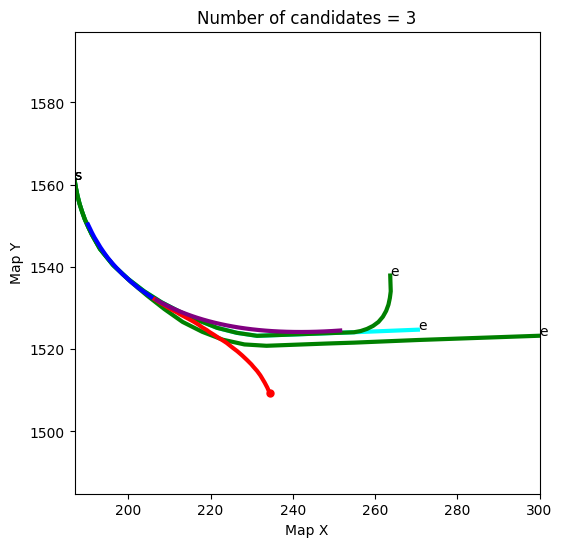

Candidate centerlines using Argoverse Map API:  0.2276468276977539


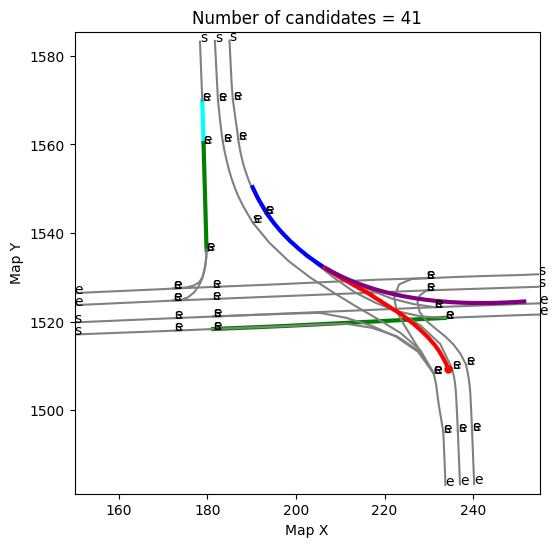

In [6]:
seq_id = 11
max_centerlines = 3
viz = True

split_name = "val"
root_dir = os.path.join(BASE_DIR,f'data/datasets/argoverse/motion-forecasting/{split_name}/data/')
seq_path = f"{root_dir}/{seq_id}.csv"

# Visualize sequence

# start = time.time()
# viz_sequence(afl.get(seq_path).seq_df, show=viz)
# end = time.time()
# print("Viz seq: ", end-start)

# Visualize centerlines

df = pd.read_csv(seq_path, dtype={"TIMESTAMP": str})
agent_track = df[df["OBJECT_TYPE"] == "AGENT"].values
agent_xy = agent_track[:,[RAW_DATA_FORMAT["X"],RAW_DATA_FORMAT["Y"]]].astype("float")
origin_pos = agent_xy[obs_len-1,:]
city_name = agent_track[0, RAW_DATA_FORMAT["CITY_NAME"]]

mode = "test"

## Using Argoverse competition baseline

start = time.time()

map_features, map_feature_helpers = map_features_utils_instance.compute_map_features(
        agent_track,
        seq_id,
        split_name,
        obs_len,
        obs_len + pred_len,
        RAW_DATA_FORMAT,
        mode, # mode (if test, return K plausible candidates. Otherwise, return best possible candidate)
        avm,
        viz=viz,
        max_candidates=max_centerlines,
        algorithm="competition" # competition, map_api, get_around  
    )

end = time.time()
print("Candidate centerlines using Argoverse forecasting baseline: ", end-start)

## Using Map API

start = time.time()

map_features, map_feature_helpers = map_features_utils_instance.compute_map_features(
        agent_track,
        seq_id,
        split_name,
        obs_len,
        obs_len + pred_len,
        RAW_DATA_FORMAT,
        mode, # mode (if test, return K plausible candidates. Otherwise, return best possible candidate)
        avm,
        viz=viz,
        max_candidates=max_centerlines,
        algorithm="map_api" # competition, map_api, get_around  
    )
map_features_ = map_features
map_feature_helpers_ = map_feature_helpers

end = time.time()
print("Candidate centerlines using Argoverse Map API: ", end-start)

### Computing lanes around center, given dist_around

start = time.time()

map_features, map_feature_helpers = map_features_utils_instance.compute_map_features(
        agent_track,
        seq_id,
        split_name,
        obs_len,
        obs_len + pred_len,
        RAW_DATA_FORMAT,
        mode, # mode (if test, return K plausible candidates. Otherwise, return best possible candidate)
        avm,
        viz=viz,
        max_candidates=max_centerlines,
        algorithm="get_around" # competition, map_api, get_around  
    )

# end = time.time()
# print("Candidate centerlines computing lanes around: ", end-start)

# # Visualize nearest centerline

# start = time.time()
# nearest_centerline = avm.get_nearest_centerline(np.array(origin_pos), city_name, visualize=viz)
# end = time.time()
# print("Nearest centerline: ", end-start)

# # Visualize lane direction in the last observation frame

# agent_traj = afl.get(seq_path).agent_traj
# start = time.time()
# lane_direction = avm.get_lane_direction(agent_traj[0], city_name, visualize=viz)
# end = time.time()
# print("Get lane direction: ", end-start)

Filter:  None
Min weight, max weight:  1 4
vel averaged:  12.064179712758381
acc averaged:  0.8782926604173452
Estimated horizon without acceleration:  36.192539138275144
Estimated horizon with acceleration:  40.1448561101532


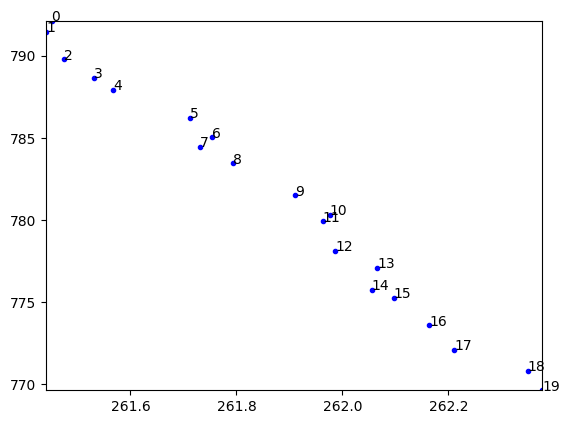

Filter:  savgol
Min weight, max weight:  1 4
vel averaged:  12.06583326986552
acc averaged:  0.676832114126277
Estimated horizon without acceleration:  36.19749980959656
Estimated horizon with acceleration:  39.2432443231648


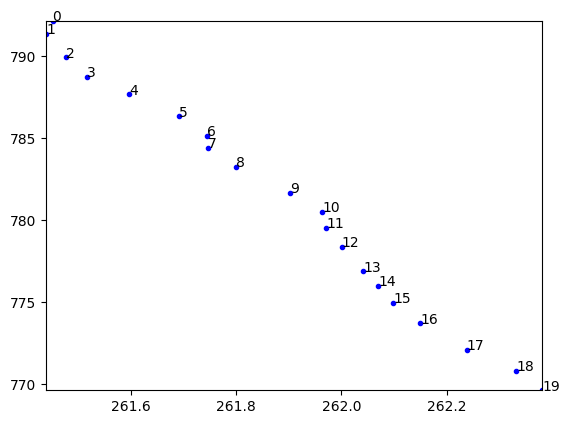

Filter:  savgol+cubic_spline
Min weight, max weight:  1 4
vel averaged:  11.597687932660936
acc averaged:  -1.384490888815608
Estimated horizon without acceleration:  34.79306379798281
Estimated horizon with acceleration:  28.562854798312575


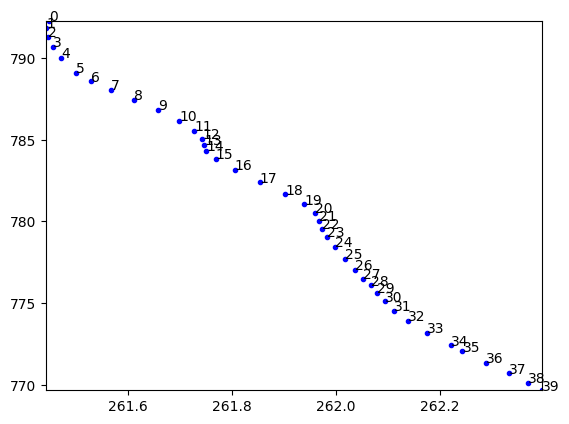

Filter:  savgol+cubic_spline
Min weight, max weight:  1 4
vel averaged:  11.597687932660936
acc averaged:  -1.384490888815608
Estimated horizon without acceleration:  34.79306379798281
Estimated horizon with acceleration:  28.562854798312575


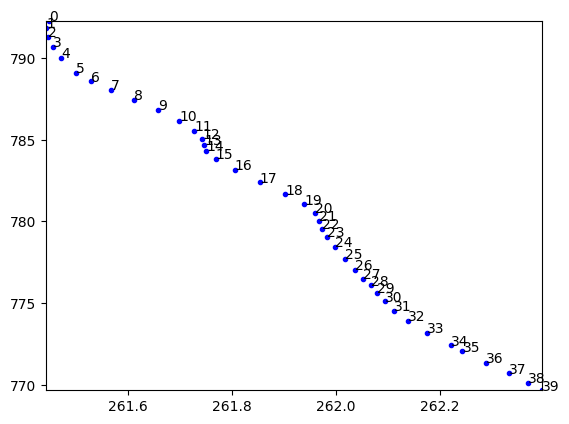

Filter:  least_squares
Min weight, max weight:  1 4
vel averaged:  12.455143890230788
acc averaged:  0.6825911929369621
Estimated horizon without acceleration:  37.36543167069237
Estimated horizon with acceleration:  40.437092038908695


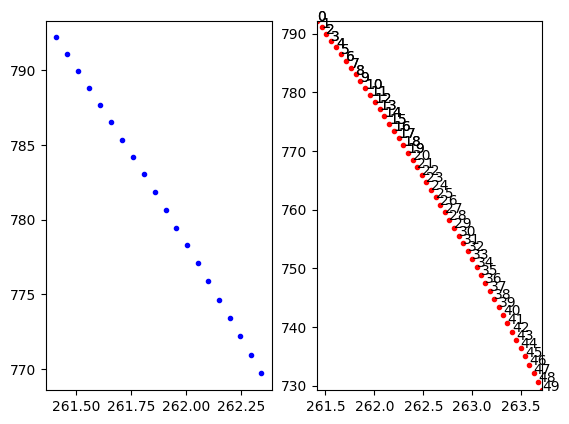

In [7]:
# seq_id = 77, split = "train"
xy = agent_xy[:obs_len,:]
xy.shape

vel, acc, xy_filtered, extended_xy_filtered = map_features_utils_instance.get_agent_velocity_and_acceleration(xy,
                                                                                                              debug=True)
vel, acc, xy_filtered, extended_xy_filtered = map_features_utils_instance.get_agent_velocity_and_acceleration(xy,
                                                                                               filter="savgol",
                                                                                               debug=True)                                                                                                              
vel, acc, xy_filtered, extended_xy_filtered = map_features_utils_instance.get_agent_velocity_and_acceleration(xy,
                                                                                               filter="savgol+cubic_spline",
                                                                                               debug=True)
vel, acc, xy_filtered, extended_xy_filtered = map_features_utils_instance.get_agent_velocity_and_acceleration(xy,
                                                                                               filter="savgol+cubic_spline",
                                                                                               debug=True)                                                                                                                                                                                             
vel, acc, xy_filtered, extended_xy_filtered = map_features_utils_instance.get_agent_velocity_and_acceleration(xy,
                                                                                               filter="least_squares",
                                                                                               debug=True)

In [129]:
distance_travelled = 0
max_dist = 100 # Hypothesis: max distance in 3 s

index_max_dist = -1

for i in range(extended_xy_filtered.shape[0]-1):
    if i >= obs_len:
        dist = np.linalg.norm((extended_xy_filtered[i+1,:] - extended_xy_filtered[i,:]))
        distance_travelled += dist

        if distance_travelled > max_dist and index_max_dist == -1:
            index_max_dist = i

reference_point = extended_xy_filtered[index_max_dist,:]

In [130]:
candidate_centerlines = map_feature_helpers["CANDIDATE_CENTERLINES"]

In [131]:
start = time.time()
distances = []
for centerline in candidate_centerlines:
    distances.append(min(np.linalg.norm((centerline - reference_point),axis=1)))
end = time.time()
print("Time: ", end-start)

Time:  0.0002627372741699219


In [132]:
unique_distances = list(set(distances))

final_indeces = [np.where(distances == unique_distance)[0][0] for unique_distance in unique_distances]

final_indeces
set(distances)

{2.1803757366837284, 3.9610525453314542, 14.85773855797649, 16.02036127595932}

In [126]:
unique_distances = list(set(distances))
unique_distances

[0.35667279425416926,
 3.3253713968144596,
 60.17858520401046,
 60.946726774477234,
 61.74980639604847]

In [ ]:
# Compute Target Agent orientation (considering the filtered input data)

: 